# Summarize performance of different backend applications

Possible options:
* Local server - running locally with `make run` on same machine as tests.
* Docker server - running locally with `make docker-run` on same machine as tests.


## How performance measurments are done

Run two terminal on testing machine.

In terminal 1 run backend server:
```bash
# cd to backend app folder, example:
cd ~/prj/vscar/back/vscar-back-fastapi/

# for local server
make run
# for docker server
make docker-run
```

In terminal 2 run performance tests:
```bash
cd ~/prj/vscar/tests/
# use run-perf-back-% target, example:
make run-perf-back-fastapi
```

Repeat for other apps

This will put csv files with measurments into `perf_test/data` folder.
If both local and docker results are needed:
* run first time for local then move manually csv files from `perf_test/data/*.csv` to `perf_test/data/local/*.csv`
    ```bash
    mv perf_test/data/*.csv perf_test/data/local/
    ```
* run second time for docker then move manually csv files from `perf_test/data/*.csv` to `perf_test/data/docker/*.csv`
    ```bash
    mv perf_test/data/*.csv perf_test/data/docker/
    ```

After that run this notebook.

### Build all backend docker images

Run:
```bash
make images-build
```

Backend docker images:
```bash
make images-show
docker images | grep "REPOSITORY\|vscar-back" | sort -k7 -h
REPOSITORY                                 TAG                        IMAGE ID       CREATED        SIZE
vscar-back-gin-app                         latest                     5933ec5524e5   2 hours ago    94.6MB
vscar-back-rocket-app                      latest                     d40bcf699b46   35 hours ago   96.8MB
vscar-back-fastapi-app                     latest                     6916df15dfe2   2 hours ago    180MB
vscar-back-ktor-app                        latest                     9490a90968ad   55 years ago   228MB
vscar-back-spring-app                      latest                     f1aa90837daa   45 years ago   274MB
vscar-back-nestjs-app                      latest                     ba870039db6a   28 hours ago   443MB
```


In [7]:
from pathlib import Path

import pandas as pd
import seaborn as sns

folder = Path("data/")
assert folder.exists() and folder.is_dir()  # noqa: PT018, S101
csvs = list(folder.glob("**/vscar*.csv"))

dfs = []
for csv in csvs:
    df_csv = pd.read_csv(csv)
    if csv.parent.name != "data":
        df_csv["server"] = csv.parent.name
    dfs.append(df_csv)

df = pd.concat(dfs)

df.head()

,Unnamed: 0,app,exec_time,response_code,request_data,parallel,server
0,0,vscar-back-fastapi,18.213272,200,"{'page': 1, 'limit': 100, 'text': '', 'attribu...",False,docker
1,1,vscar-back-fastapi,3.675938,200,"{'page': 1, 'limit': 100, 'text': '', 'attribu...",False,docker
2,2,vscar-back-fastapi,15.332937,200,"{'page': 1, 'limit': 100, 'text': '', 'attribu...",False,docker
3,3,vscar-back-fastapi,3.679276,200,"{'page': 1, 'limit': 100, 'text': '', 'attribu...",False,docker
4,4,vscar-back-fastapi,1.790285,200,"{'page': 1, 'limit': 100, 'text': '', 'attribu...",False,docker


# Check for code responses

In [8]:
df["response_code"].unique()

array([200, 201])

In [9]:
df_avg = df.groupby(["app", "parallel", "server"])["exec_time"].mean().reset_index()
df_avg.head()

,app,parallel,server,exec_time
0,vscar-back-fastapi,False,docker,45.397833
1,vscar-back-fastapi,False,local,41.041110
2,vscar-back-fastapi,True,docker,133.703248
3,vscar-back-fastapi,True,local,114.289267
4,vscar-back-gin,False,docker,12.986017


               app  parallel server  exec_time
vscar-back-fastapi     False docker  45.397833
vscar-back-fastapi     False  local  41.041110
    vscar-back-gin     False docker  12.986017
    vscar-back-gin     False  local  13.036458
   vscar-back-ktor     False docker  11.815501
   vscar-back-ktor     False  local  11.414484
 vscar-back-nestjs     False docker  10.158257
 vscar-back-nestjs     False  local   8.734374
 vscar-back-rocket     False docker  12.361358
 vscar-back-rocket     False  local  12.398532
 vscar-back-spring     False docker  10.302499
 vscar-back-spring     False  local  20.959413
vscar-back-fastapi      True docker 133.703248
vscar-back-fastapi      True  local 114.289267
    vscar-back-gin      True docker  64.361829
    vscar-back-gin      True  local  22.112193
   vscar-back-ktor      True docker  44.864080
   vscar-back-ktor      True  local  17.567519
 vscar-back-nestjs      True docker  87.248746
 vscar-back-nestjs      True  local  77.111068
 vscar-back-r

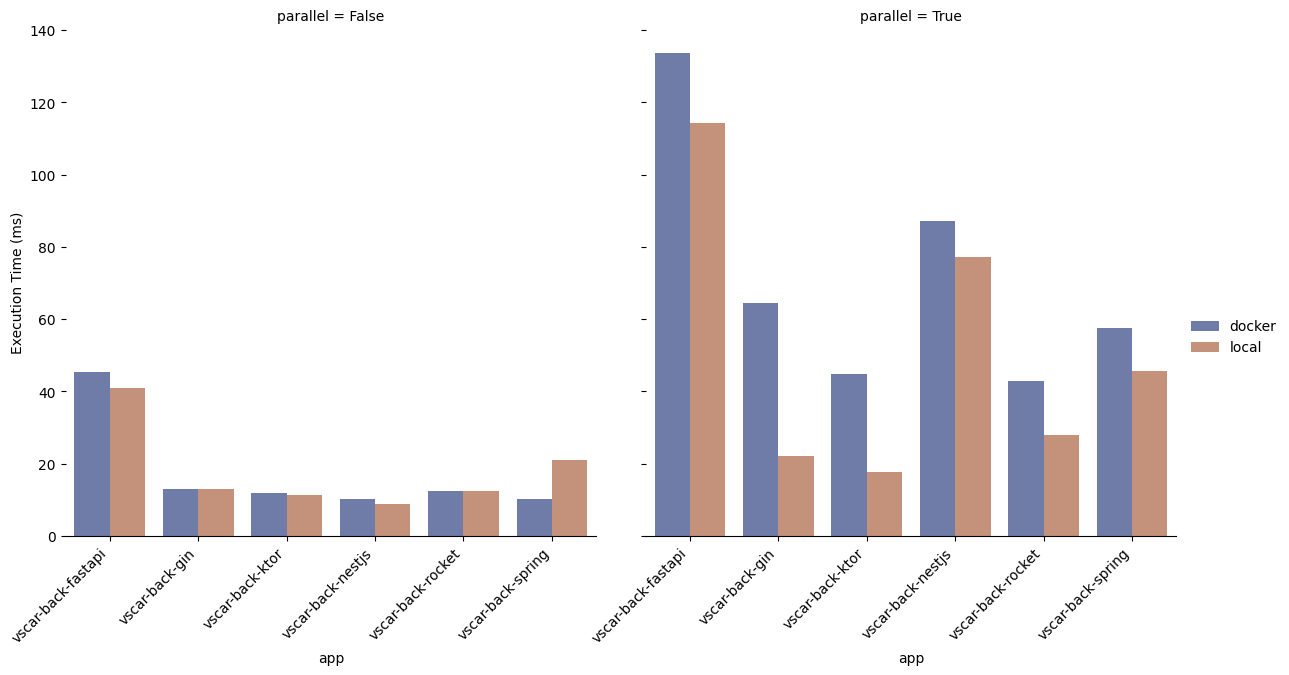

In [10]:
g = sns.catplot(
    data=df_avg,
    kind="bar",
    x="app",
    y="exec_time",
    hue="server",
    col="parallel",
    errorbar="sd",
    palette="dark",
    alpha=0.6,
    height=6,
)
g.despine(left=True)
g.set_axis_labels("app", "Execution Time (ms)")
g.legend.set_title("")
g.set_xticklabels(rotation=45, ha="right")

print(df_avg.sort_values(["parallel", "app", "server"]).to_string(index=False))  # noqa: T201